# Clean file with modules

In [12]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
parent_dir1 = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(parent_dir1)

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from simspice.data.SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import simspice.utils.inverse_mapping_functions as imf
import simspice.models.Siamese_Architecture as SA
# import simspice.models.Siamese_Architecture_Transformer as SA
import wandb
#import umap.umap_ as umap
import tqdm
from datetime import datetime

plt.rcParams['image.origin'] = 'lower'

BATCH_SIZE = 64

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [14]:
simspice = "/d0/tvaresano/SimSPICE/"

In [16]:
dataset_path = simspice+"spectra_train.nc"
dataset_log = SproutDataset(dataset_path=dataset_path, augmentation_type='double', csv_files='/d0/tvaresano/SimSPICE/L2_names.csv',
                                           log_space=False, normalize_intensity=False)

dataloader = DataLoader(
            dataset_log,
            batch_size=BATCH_SIZE,
            shuffle=True)

## Train model

In [ ]:
model = SA.SimSiam(output_dim=64, backbone_output_dim=128, hidden_layer_dim=128)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

wandb_logger = WandbLogger(project="runs_double_augmentation", name=f"fullTrained_outdim64_{datetime.today().strftime('%Y-%m-%d')}", log_model=True)

trainer = pl.Trainer(max_epochs=25, devices=1, accelerator=accelerator, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: tava8993 (tava8993-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | backbone        | Siamese1DNet_backbone | 6.6 K  | train
1 | projection_head | SimSiamProjectionHead | 41.5 K | train
2 | prediction_head | SimSiamPredictionHead | 16.7 K | train
3 | criterion       | NTXentLoss            | 0      | train
------------------------------------------------------------------
64.8 K    Trainable params
0         Non-trainable params
64.8 K    Total params
0.259     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Epoch 0:   7%|▋         | 1334/18150 [01:47<22:41, 12.35it/s, v_num=6d64]

## If loading from previous checkpoint

In [ ]:
# checkpoint = simspice+"notebooks/runs_double_augmentation/iv8w6mey/checkpoints/epoch=9-step=181500.ckpt"
# model = SA.SimSiam.load_from_checkpoint(checkpoint)  # Continue epochs

# accelerator = "gpu" if torch.cuda.is_available() else "cpu"
# wandb_logger = WandbLogger(project="runs_double_augmentation", name=f"fullTrained_outdim64_log_{datetime.today().strftime('%Y-%m-%d')}", log_model=True)
# trainer = pl.Trainer(max_epochs=15, devices=1, accelerator=accelerator, logger=wandb_logger)
# trainer.fit(model=model, train_dataloaders=dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


wandb: Currently logged in as: tava8993 (tava8993-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | backbone        | Siamese1DNet_backbone | 924 K  | train
1 | projection_head | SimSiamProjectionHead | 41.5 K | train
2 | prediction_head | SimSiamPredictionHead | 16.7 K | train
3 | criterion       | NTXentLoss            | 0      | train
------------------------------------------------------------------
982 K     Trainable params
0         Non-trainable params
982 K     Total params
3.930     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 18150/18150 [32:13<00:00,  9.39it/s, v_num=p2kb]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 18150/18150 [32:13<00:00,  9.39it/s, v_num=p2kb]


-------------------------------------------------------------------

In [ ]:
dataset_path = simspice+"spectra_Feb2023.nc"
dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None, csv_files=simspice+'L2_names.csv',
                                           log_space=True, normalize_intensity=False)
checkpoint = simspice+'notebooks/runs_double_augmentation/iv8w6mey/checkpoints/epoch=24-step=453750.ckpt'
outputs = SA.run_model(checkpoint, dataset_none)
# model.eval()
# outputs = []
# with torch.no_grad():  # Disable gradient computation for inference
#     for i in tqdm.tqdm(range (dataset_none.__len__())):
#         spec = dataset_none.__getitem__(i).unsqueeze(0)
#         # Move tensor to the same device as the model
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         model = model.to(device)
#         spec = spec.to(device)

#         outputs.append(model(spec)[0].cpu().numpy())

100%|██████████| 116160/116160 [02:58<00:00, 651.20it/s]


In [ ]:
# checkpoint = "C:\\Users\\tania\Documents\CU Boulder\CU Alpine\models_ckpts\single_epoch=4-step=45750.ckpt"
# dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None)
# outputs = SA.run_model(checkpoint, dataset_none)

In [ ]:
stacked_outputs = np.stack(outputs).squeeze()
stacked_outputs.shape
np.save(simspice+'notebooks/jobs/model_outputs/stacked_outputs_double64_full_log.npy', stacked_outputs)

In [ ]:
stacked_outputs = np.load(simspice+'notebooks/jobs/model_outputs/stacked_outputs_double64_full_log.npy')

### Test clustering with various parameters

In [ ]:
for x in [10, 20, 30]:
    for y in tqdm.tqdm([5, 10, 15]):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean') # <=> cosine?
        clusterer.fit(stacked_outputs)
        labels = clusterer.labels_
        np.save(simspice+f'notebooks/jobs/clustering/Fulltrained_double_log_minclus{x}_minsamp{y}.npy', labels)

100%|██████████| 3/3 [24:49<00:00, 496.52s/it]


Unique Clusters: 116
Unique Clusters: 60
Unique Clusters: 36
Unique Clusters: 49
Unique Clusters: 39
Unique Clusters: 24
Unique Clusters: 35
Unique Clusters: 24
Unique Clusters: 18


Text(0.5, 0.98, 'Feb23_double_log_full_trained')

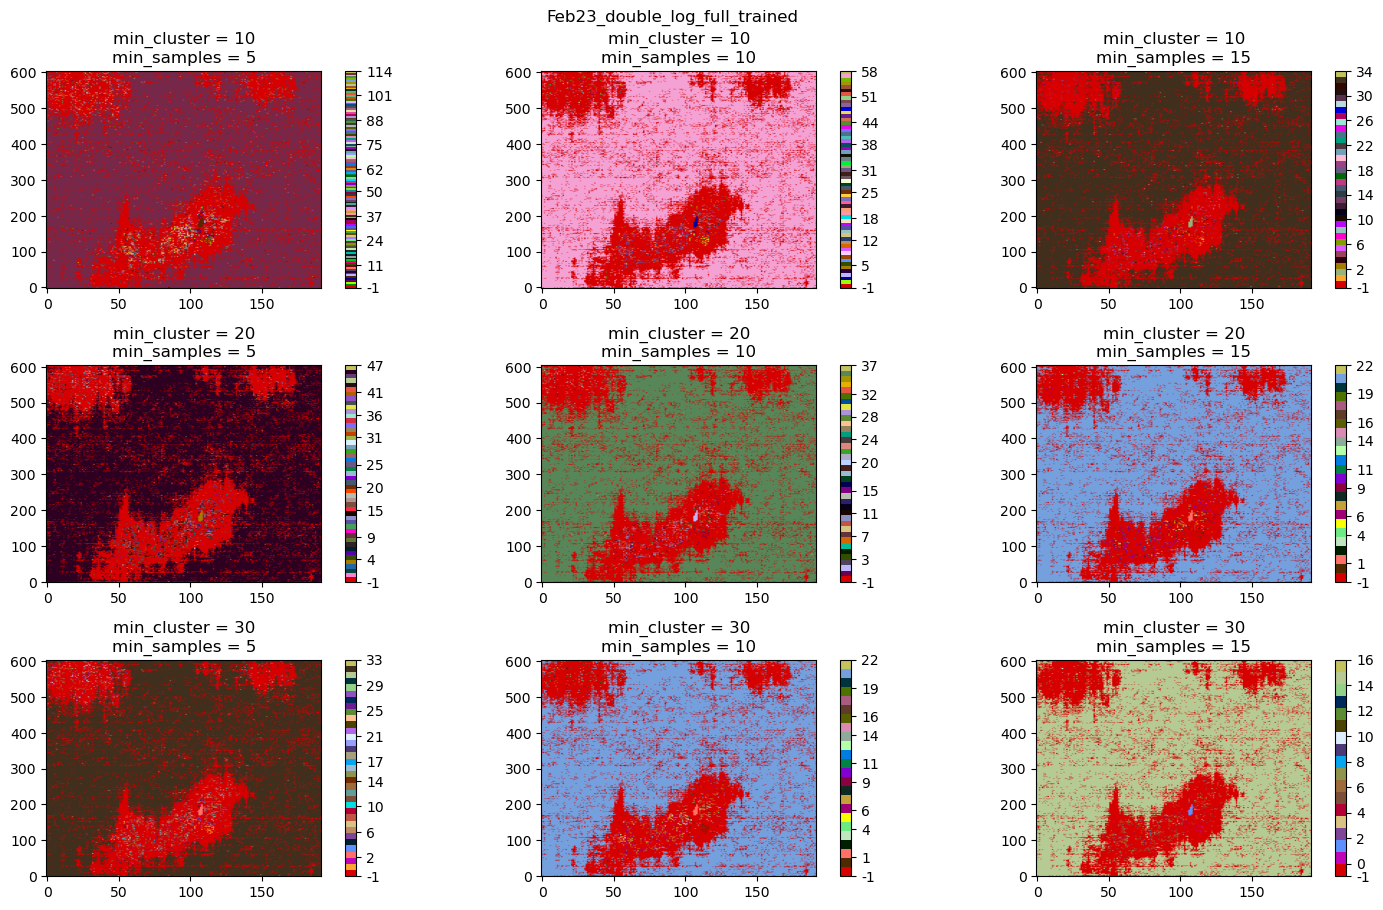

In [ ]:
c=0
dataset_path = simspice+"spectra_Feb2023.nc"
plt.figure(figsize=(15,12), tight_layout=True)
for x in [10, 20, 30]:
    for y in [5, 10, 15]:
        c+=1
        plt.subplot(4,3,c)
        labels = np.load(simspice+f'notebooks/jobs/clustering/Fulltrained_double_log_minclus{x}_minsamp{y}.npy')
        imf.map_clusters(labels, dataset_path=dataset_path, selected_clusters=None)
        plt.title(f"min_cluster = {x}\nmin_samples = {y}")
plt.suptitle('Feb23_double_log_full_trained')

### Plot average spectra for a single cluster

In [ ]:
x,y = (30,10)
labels = np.load(f'saved_outputs//labels_double_normspec_15epochs_Feb23_minclus{x}_minsamp{y}.npy')

In [ ]:
current_labels = labels.reshape(610, 192)
unique_clusters = np.unique(current_labels[~np.isnan(current_labels)])

In [ ]:
# imf.plot_n_random_spectra_cluster(labels, stacked_outputs, chosen_cluster=1, dataset=dataset_none, nbr_items=len(np.where(labels==1)[0]), plot_on_map=False, log_scale=False,
#                                   dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

for i in unique_clusters:
    av_spectra = imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=i, dataset=dataset_none, log_scale=False,
                                  dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

-------------------------------------------------------------------------------